In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt

import itables
from itables import show

In [ ]:
# Загрузка данных
path = 'data_eda.csv'
data = pd.read_csv(path).drop(columns=['Unnamed: 0', 'CC50, mM','SI'], axis=1).rename(columns={'IC50, mM': 'IC50'})
data.head(3)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiazole,fr_thiophene,fr_unbrch_alkane,IC50
0,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,0.038844,-0.293526,0.642857,14.822266,...,0,0,0,0,0,0,0,0,3,6.239374
1,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,0.012887,-0.313407,0.607143,14.975110,...,0,0,0,0,0,0,0,0,3,0.771831
2,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,0.094802,-0.325573,0.562500,15.353938,...,0,0,0,0,2,0,0,0,3,223.808778


In [ ]:
show(data.corr()['IC50'])

Loading ITables v2.4.2 from the internet... (need help?)


In [ ]:
mean = data['IC50'].mean()
std = data['IC50'].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

data["outlier"] = (data['IC50'] < lower_bound) | (data['IC50'] > upper_bound)
data['outlier_3'] = (data['IC50'] < lower_bound) | (data['IC50'] > upper_bound)
data_cleaned = data[~data['outlier_3']].drop(columns=['outlier', 'outlier_3'])

In [ ]:
X = data_cleaned.drop('IC50', axis=1)
y = data_cleaned['IC50']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def define_target_value(value):
  if value > median:
    return 1

  return 0

median = y_train.median()
y_train = y_train.apply(define_target_value)
y_test = y_test.apply(define_target_value)

In [ ]:
data_cleaned['target'] = data_cleaned['IC50'].apply(define_target_value)

# Отбор признаков

In [ ]:
def correlation_feature_selections(df, target_col, threshold=0.1):
    # Оставляем только числовые признаки
    df_numeric = df.select_dtypes(include=[float, int])

    # Вычисляем корреляции с целевой переменной
    correlations = df_numeric.corr()[target_col].abs().sort_values(ascending=False)

    # Отбираем признаки с корреляцией выше порога
    selected_features = correlations[correlations > threshold].index.tolist()
    selected_features.remove(target_col)  # удаляем целевую переменную из признаков

    print(f"Выбранные признаки ({len(selected_features)}): {selected_features}")
    return selected_features

In [ ]:
selected_features_by_corr = correlation_feature_selections(data_cleaned.drop('IC50', axis=1), target_col='target')

Выбранные признаки (24): ['NumSaturatedHeterocycles', 'NumAliphaticHeterocycles', 'SMR_VSA4', 'VSA_EState4', 'EState_VSA8', 'fr_NH2', 'NumAromaticHeterocycles', 'VSA_EState7', 'SMR_VSA5', 'PEOE_VSA6', 'fr_furan', 'EState_VSA5', 'PEOE_VSA7', 'fr_Ndealkylation2', 'EState_VSA6', 'fr_NH1', 'MinEStateIndex', 'BCUT2D_MWLOW', 'fr_ketone', 'MaxAbsEStateIndex', 'fr_priamide', 'EState_VSA4', 'SlogP_VSA8', 'PEOE_VSA4']


In [ ]:
def random_forest_feature_selection(df, target_col, n_top=20):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Разделение на трейн/тест
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем модель
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Получаем важность признаков
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Выводим топ-N самых важных
    top_features = importance.head(n_top).index.tolist()
    print(f"Топ-{n_top} важных признаков:\n", top_features)

    # График важности
    importance.nlargest(n_top).plot(kind='barh', figsize=(10, 8))
    plt.title("Feature Importance")
    plt.show()

    return top_features

Топ-10 важных признаков:
 ['BCUT2D_MRLOW', 'NumSaturatedHeterocycles', 'SMR_VSA5', 'VSA_EState5', 'VSA_EState4', 'EState_VSA6', 'SPS', 'EState_VSA8', 'PEOE_VSA6', 'MolLogP']


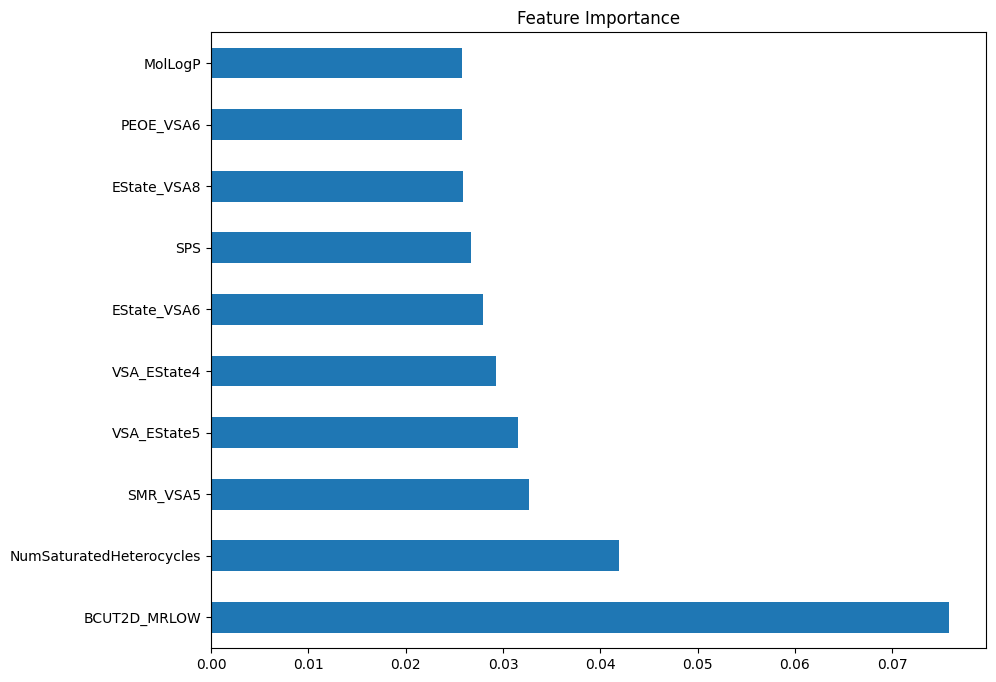

In [ ]:
selected_features_by_rand_for = random_forest_feature_selection(data_cleaned.drop('IC50', axis=1), target_col='target', n_top=10)

In [ ]:
def lasso_feature_selection(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Стандартизируем данные
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Подбор оптимального alpha и обучение Lasso
    model = LassoCV(cv=5, random_state=42, max_iter=10000)
    model.fit(X_scaled, y)

    # Определяем, какие признаки не занулены
    coef = pd.Series(model.coef_, index=X.columns)
    selected_features = coef[coef != 0].index.tolist()

    print(f"Коэффициенты:\n{coef.sort_values(ascending=False)}")
    print(f"Оставлено признаков: {len(selected_features)}")
    print("Оставленные признаки:", selected_features)

    return selected_features

In [ ]:
selected_features_by_lasso = lasso_feature_selection(data_cleaned.drop('IC50', axis=1), target_col='target')

Коэффициенты:
NumSaturatedHeterocycles    0.098755
NumAromaticHeterocycles     0.041748
BCUT2D_CHGLO                0.027276
EState_VSA7                 0.022600
fr_furan                    0.021786
                              ...   
EState_VSA4                -0.035741
fr_ketone                  -0.038059
PEOE_VSA6                  -0.040101
fr_NH1                     -0.053368
fr_priamide                -0.059257
Length: 94, dtype: float64
Оставлено признаков: 35
Оставленные признаки: ['MinEStateIndex', 'MinPartialCharge', 'BCUT2D_MWLOW', 'BCUT2D_CHGLO', 'BCUT2D_MRLOW', 'PEOE_VSA6', 'SMR_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'VSA_EState5', 'NumAliphaticHeterocycles', 'NumAromaticHeterocycles', 'NumSaturatedHeterocycles', 'fr_Al_COO', 'fr_Ar_OH', 'fr_C_S', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation2', 'fr_allylic_oxid', 'fr_aryl_methyl', 'fr_epoxide', 'fr_ester', 'fr_furan', 'fr_ketone', 'fr_methoxy', 'fr_morpholine', 'fr_nitro

# Подбор гиперпарметров

In [ ]:
def get_models():
  return {
      "Logistic Regression": {
          "model": LogisticRegression(),
          "params": {
              'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear']
          }
      },
      "Random Forest": {
          "model": RandomForestClassifier(random_state=42),
          "params": {
              'n_estimators': [50, 100, 200],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'criterion': ['gini', 'entropy']
          }
      },
      "Gradient Boosting": {
          "model": GradientBoostingClassifier(random_state=42),
          "params": {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7],
              'subsample': [0.8, 1.0],
              'min_samples_split': [2, 5]
          }
      },
      "XGBoost": {
          "model": XGBClassifier(random_state=42, eval_metric='logloss'),
          "params": {
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 5, 7],
              'colsample_bytree': [0.7, 1.0],
              'subsample': [0.8, 1.0]
          }
      },
      "CatBoost": {
          "model": CatBoostClassifier(random_seed=42, verbose=0),
          "params": {
              'iterations': [100, 200],
              'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 6, 8],
              'l2_leaf_reg': [1, 3, 5, 7]
          }
      },
      "KNN": {
          "model": KNeighborsClassifier(),
          "params": {
              'n_neighbors': [3, 5, 7, 10],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]  # 1 - Manhattan, 2 - Euclidean
          }
      }
  }

In [ ]:
def start_classification(X_train_final, X_test_final):
  models = get_models()
  results = []

  for model_name, config in models.items():
      print(f"\nОбучение модели: {model_name}")

      if not config['params']:  # если нет параметров для подбора
          model = config['model']
          model.fit(X_train_final, y_train)
          best_params = {}
      else:
          # Используем Accuracy как основную метрику для подбора гиперпараметров
          grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='f1_weighted', n_jobs=-1)
          grid.fit(X_train_final, y_train)
          model = grid.best_estimator_
          best_params = grid.best_params_

      # Предсказания
      y_pred = model.predict(X_test_final)

      # Для ROC AUC нужен predict_proba (если модель его поддерживает)
      if hasattr(model, "predict_proba"):
          y_proba = model.predict_proba(X_test_final)[:, 1]
      else:
          y_proba = None

      # Метрики
      accuracy = accuracy_score(y_test, y_pred)
      precision = precision_score(y_test, y_pred)
      recall = recall_score(y_test, y_pred)
      f1 = f1_score(y_test, y_pred)

      # Если есть вероятности, считаем ROC AUC
      if y_proba is not None:
          roc_auc = roc_auc_score(y_test, y_proba)
      else:
          roc_auc = None

      results.append({
          "Model": model_name,
          "Best Params": best_params,
          "Accuracy": accuracy,
          "Precision": precision,
          "Recall": recall,
          "F1 Score": f1,
          "ROC AUC": roc_auc
      })

      print(f"Лучшие параметры: {best_params}")
      print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
      if roc_auc is not None:
          print(f"ROC AUC: {roc_auc:.4f}")
  return results

# Результаты

In [ ]:
X_train_final = X_train[selected_features_by_corr]
X_test_final = X_test[selected_features_by_corr]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res1 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression
Лучшие параметры: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.6440, Precision: 0.6842, Recall: 0.6311, F1: 0.6566
ROC AUC: 0.7167

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.7068, Precision: 0.7701, Recall: 0.6505, F1: 0.7053
ROC AUC: 0.7540

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.6387, Precision: 0.6809, Recall: 0.6214, F1: 0.6497
ROC AUC: 0.6915

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.6440, Precision: 0.7273, Recall: 0.5437, F1: 0.6222
ROC AUC: 0.7359

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate'

In [ ]:
X_train_final = X_train[selected_features_by_lasso]
X_test_final = X_test[selected_features_by_lasso]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res2 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression
Лучшие параметры: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.6911, Precision: 0.7200, Recall: 0.6990, F1: 0.7094
ROC AUC: 0.7568

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.6597, Precision: 0.7111, Recall: 0.6214, F1: 0.6632
ROC AUC: 0.7534

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.6545, Precision: 0.6729, Recall: 0.6990, F1: 0.6857
ROC AUC: 0.7100

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.6387, Precision: 0.7024, Recall: 0.5728, F1: 0.6310
ROC AUC: 0.7198

Обучение модели: CatBoost
Лучшие параметры: {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0

In [ ]:
X_train_final = X_train[selected_features_by_rand_for]
X_test_final = X_test[selected_features_by_rand_for]
scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.fit_transform(X_test_final)
res3 = start_classification(X_train_final, X_test_final)


Обучение модели: Logistic Regression
Лучшие параметры: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.5812, Precision: 0.6211, Recall: 0.5728, F1: 0.5960
ROC AUC: 0.6494

Обучение модели: Random Forest
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.6702, Precision: 0.7564, Recall: 0.5728, F1: 0.6519
ROC AUC: 0.7252

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.6597, Precision: 0.7500, Recall: 0.5534, F1: 0.6369
ROC AUC: 0.7166

Обучение модели: XGBoost
Лучшие параметры: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.6649, Precision: 0.7468, Recall: 0.5728, F1: 0.6484
ROC AUC: 0.7086

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_r

Лучше всего себя показал KNN, в котором сочетался общий баланс метрик и при этом высокая уверенность в прогнозах среди всех остальных моделей. Обучена модель была на данных, признаки для которой отбирались с помощью Лассо.
Гиперпараметры для этой модели, которые дали наилучшие результаты, следующие:

-	n_neighbors: 5
-	p: 1
-	weights: uniform

Ниже перечислены получившиеся метрики:

-	Accuracy: 0.7016
-	Precision: 0.7674
-	Recall: 0.6408
-	F1: 0.6984
-	ROC AUC: 0.7644
